## Using Scikit-Learn and NLTK to build a Naive Bayes Classifier that identifies subtweets

### Goals:
#### Use Scikit-Learn pipelines to define special features to add to a Naive Bayes Classifier
#### Evaluate the accuracy of the classifier
#### Maybe do it live, on a Twitter API stream

### Methods:
#### Use the training set I made before

#### Import libraries

In [1]:
%matplotlib inline

In [2]:
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.feature_extraction import DictVectorizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.externals import joblib
from textblob import TextBlob
from time import sleep
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import itertools
import datetime
import tweepy
import nltk
import re

#### Set max column width for dataframes

In [3]:
pd.set_option("max_colwidth", 280)

#### Load the CSV

In [4]:
df = pd.read_csv("../data/training_data/Subtweets_Classifier_Training_Data.csv")

#### Create training and test sets from the single training set I made before

In [5]:
text_train, text_test, class_train, class_test = train_test_split(df.alleged_subtweet.tolist(), 
                                                                  df.is_subtweet.tolist())

#### Use NLTK's tokenizer instead of Scikit's

In [6]:
tokenizer = nltk.casual.TweetTokenizer(preserve_case=False, reduce_len=True)

#### Class for distinguishing polarizing parts of speech as features

In [7]:
class TweetStats(BaseEstimator, TransformerMixin):
    def fit(self, x, y=None):
        return self

    def transform(self, posts):
        first_names = ["Aaliyah", "Aaron", "Abby", "Abigail", "Abraham", "Adam",
                       "Addison", "Adrian", "Adriana", "Adrianna", "Aidan", "Aiden",
                       "Alan", "Alana", "Alejandro", "Alex", "Alexa", "Alexander",
                       "Alexandra", "Alexandria", "Alexia", "Alexis", "Alicia", "Allison",
                       "Alondra", "Alyssa", "Amanda", "Amber", "Amelia", "Amy",
                       "Ana", "Andrea", "Andres", "Andrew", "Angel", "Angela",
                       "Angelica", "Angelina", "Anna", "Anthony", "Antonio", "Ariana",
                       "Arianna", "Ashley", "Ashlyn", "Ashton", "Aubrey", "Audrey",
                       "Austin", "Autumn", "Ava", "Avery", "Ayden", "Bailey",
                       "Benjamin", "Bianca", "Blake", "Braden", "Bradley", "Brady",
                       "Brandon", "Brayden", "Breanna", "Brendan", "Brian", "Briana",
                       "Brianna", "Brittany", "Brody", "Brooke", "Brooklyn", "Bryan",
                       "Bryce", "Bryson", "Caden", "Caitlin", "Caitlyn", "Caleb",
                       "Cameron", "Camila", "Carlos", "Caroline", "Carson", "Carter",
                       "Cassandra", "Cassidy", "Catherine", "Cesar", "Charles", "Charlotte",
                       "Chase", "Chelsea", "Cheyenne", "Chloe", "Christian", "Christina",
                       "Christopher", "Claire", "Cody", "Colby", "Cole", "Colin",
                       "Collin", "Colton", "Conner", "Connor", "Cooper", "Courtney",
                       "Cristian", "Crystal", "Daisy", "Dakota", "Dalton", "Damian",
                       "Daniel", "Daniela", "Danielle", "David", "Delaney", "Derek",
                       "Destiny", "Devin", "Devon", "Diana", "Diego", "Dominic",
                       "Donovan", "Dylan", "Edgar", "Eduardo", "Edward", "Edwin",
                       "Eli", "Elias", "Elijah", "Elizabeth", "Ella", "Ellie", 
                       "Emily", "Emma", "Emmanuel", "Eric", "Erica", "Erick",
                       "Erik", "Erin", "Ethan", "Eva", "Evan", "Evelyn",
                       "Faith", "Fernando", "Francisco", "Gabriel", "Gabriela", "Gabriella",
                       "Gabrielle", "Gage", "Garrett", "Gavin", "Genesis", "George",
                       "Gianna", "Giovanni", "Giselle", "Grace", "Gracie", "Grant",
                       "Gregory", "Hailey", "Haley", "Hannah", "Hayden", "Hector",
                       "Henry", "Hope", "Hunter", "Ian", "Isaac", "Isabel",
                       "Isabella", "Isabelle", "Isaiah", "Ivan", "Jack", "Jackson",
                       "Jacob", "Jacqueline", "Jada", "Jade", "Jaden", "Jake",
                       "Jalen", "James", "Jared", "Jasmin", "Jasmine", "Jason", 
                       "Javier", "Jayden", "Jayla", "Jazmin", "Jeffrey", "Jenna",
                       "Jennifer", "Jeremiah", "Jeremy", "Jesse", "Jessica", "Jesus",
                       "Jillian", "Jocelyn", "Joel", "John", "Johnathan", "Jonah",
                       "Jonathan", "Jordan", "Jordyn", "Jorge", "Jose", "Joseph",
                       "Joshua", "Josiah", "Juan", "Julia", "Julian", "Juliana",
                       "Justin", "Kaden", "Kaitlyn", "Kaleb", "Karen", "Karina",
                       "Kate", "Katelyn", "Katherine", "Kathryn", "Katie", "Kayla",
                       "Kaylee", "Kelly", "Kelsey", "Kendall", "Kennedy", "Kenneth",
                       "Kevin", "Kiara", "Kimberly", "Kyle", "Kylee", "Kylie",
                       "Landon", "Laura", "Lauren", "Layla", "Leah", "Leonardo",
                       "Leslie", "Levi", "Liam", "Liliana", "Lillian", "Lilly",
                       "Lily", "Lindsey", "Logan", "Lucas", "Lucy", "Luis",
                       "Luke", "Lydia", "Mackenzie", "Madeline", "Madelyn", "Madison",
                       "Makayla", "Makenzie", "Malachi", "Manuel", "Marco", "Marcus",
                       "Margaret", "Maria", "Mariah", "Mario", "Marissa", "Mark",
                       "Martin", "Mary", "Mason", "Matthew", "Max", "Maxwell",
                       "Maya", "Mckenzie", "Megan", "Melanie", "Melissa", "Mia",
                       "Micah", "Michael", "Michelle", "Miguel", "Mikayla", "Miranda",
                       "Molly", "Morgan", "Mya", "Naomi", "Natalia", "Natalie",
                       "Nathan", "Nathaniel", "Nevaeh", "Nicholas", "Nicolas", "Nicole",
                       "Noah", "Nolan", "Oliver", "Olivia", "Omar", "Oscar",
                       "Owen", "Paige", "Parker", "Patrick", "Paul", "Payton",
                       "Peter", "Peyton", "Preston", "Rachel", "Raymond", "Reagan",
                       "Rebecca", "Ricardo", "Richard", "Riley", "Robert", "Ruby",
                       "Ryan", "Rylee", "Sabrina", "Sadie", "Samantha", "Samuel",
                       "Sara", "Sarah", "Savannah", "Sean", "Sebastian", "Serenity",
                       "Sergio", "Seth", "Shane", "Shawn", "Shelby", "Sierra",
                       "Skylar", "Sofia", "Sophia", "Sophie", "Spencer", "Stephanie",
                       "Stephen", "Steven", "Summer", "Sydney", "Tanner", "Taylor", 
                       "Thomas", "Tiffany", "Timothy", "Travis", "Trenton", "Trevor",
                       "Trinity", "Tristan", "Tyler", "Valeria", "Valerie", "Vanessa",
                       "Veronica", "Victor", "Victoria", "Vincent", "Wesley", "William",
                       "Wyatt", "Xavier", "Zachary", "Zoe", "Zoey"]
        first_names_lower = set([name.lower() for name in first_names])

        pronouns = ["You", "You're", "Your", 
                    "She", "She's", "Her", "Hers", 
                    "He", "He's", "Him", "His", 
                    "They", "They're", "Them", "Their", "Theirs"]
        prounouns_lower = set([pronoun.lower() for pronoun in pronouns])

        pattern = "(?:http|ftp|https)://(?:[\w_-]+(?:(?:\.[\w_-]+)+))(?:[\w.,@?^=%&:/~+#-]*[\w@?^=%&/~+#-])?"
        
        final_output = []
        for text in posts:
            tokenized_text = tokenizer.tokenize(text)
            weighted_dict = {"length": len(text), 
                             "good": len(prounouns_lower.intersection(tokenized_text)), 
                             "bad": (len(first_names_lower.intersection(tokenized_text)) 
                                     + text.count("@") 
                                     + text.count("subtweet") 
                                     + text.count("Subtweet") 
                                     + len(re.findall(pattern, text)))}
            final_output.append(weighted_dict)
        return final_output

#### Build the pipeline

In [8]:
sentiment_pipeline = Pipeline([
    ("features", FeatureUnion([
        ("ngram_tf_idf", Pipeline([
            ("counts", CountVectorizer(tokenizer=tokenizer.tokenize)),
            ("tf_idf", TfidfTransformer())
        ])),
        ("stats_vect", Pipeline([
            ("tweet_stats", TweetStats()),
            ("vect", DictVectorizer()),
        ])),
    ])),
    ("classifier", MultinomialNB())
])

#### Show the results

In [9]:
sentiment_pipeline.fit(text_train, class_train)
predictions = sentiment_pipeline.predict(text_test)

In [10]:
print(classification_report(class_test, predictions))

             precision    recall  f1-score   support

   negative       0.94      0.87      0.90      1863
   positive       0.87      0.94      0.90      1820

avg / total       0.90      0.90      0.90      3683



#### Define function for visualizing confusion matrices

In [11]:
def plot_confusion_matrix(cm, classes, normalize=False,
                          title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

#### Show the matrices

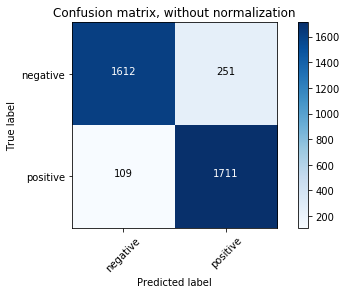

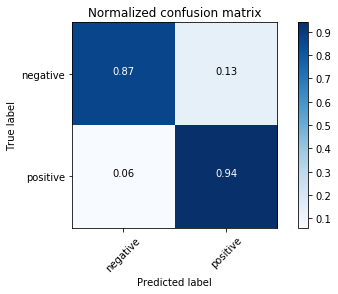

In [12]:
class_names = ["negative", "positive"]

cnf_matrix = confusion_matrix(class_test, predictions)
np.set_printoptions(precision=2)

plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

#### Save the classifier for another time

In [13]:
joblib.dump(sentiment_pipeline, "../data/non_subtweets_data/subtweets_classifier.pkl") 

['../data/non_subtweets_data/subtweets_classifier.pkl']

#### Print tests for the classifier

In [14]:
def tests_dataframe(tweets_dataframe, text_column="SentimentText", sentiment_column="Sentiment"):
    predictions = sentiment_pipeline.predict_proba(tweets_dataframe[text_column])
    negative_probability = predictions[:, 0].tolist()
    positive_probability = predictions[:, 1].tolist()
    return pd.DataFrame({"tweet": tweets_dataframe[text_column], 
                         "sentiment_score": tweets_dataframe[sentiment_column], 
                         "subtweet_negative_probability": negative_probability, 
                         "subtweet_positive_probability": positive_probability}).sort_values(by="subtweet_positive_probability", 
                                                                                             ascending=False)

#### Make up some tweets

In [15]:
test_tweets = ["Some people don't know their place.", 
               "Isn't it funny how some people don't know their place?", 
               "How come you people act like this?", 
               "You're such a nerd.",
               "I love Noah, he's so cool.",
               "Who the heck is Noah?",
               "This is a @NoahSegalGould subtweet. Go check out https://segal-gould.com.", 
               "This is a subtweet.", 
               "Hey @jack!", 
               "Hey Jack!",
               "http://www.google.com"]

#### Make a dataframe from the list

In [16]:
test_tweets_df = pd.DataFrame({"Tweet": test_tweets, "Sentiment": [None]*len(test_tweets)})

#### Print the tests

In [17]:
tests_dataframe(test_tweets_df, text_column="Tweet", sentiment_column="Sentiment").head()

,sentiment_score,subtweet_negative_probability,subtweet_positive_probability,tweet
2,None,0.053810,0.946190,How come you people act like this?
1,None,0.056352,0.943648,Isn't it funny how some people don't know their place?
0,None,0.065283,0.934717,Some people don't know their place.
3,None,0.387945,0.612055,You're such a nerd.
7,None,0.632935,0.367065,This is a subtweet.


#### Test on actual tweets

In [18]:
naji_df = pd.read_csv("../data/non_subtweets_data/naji_data.csv", error_bad_lines=False)

b'Skipping line 8836: expected 4 fields, saw 5\n'
b'Skipping line 535882: expected 4 fields, saw 7\n'


#### Repair some leftover HTML

In [19]:
naji_df["SentimentText"] = naji_df["SentimentText"].str.replace("&quot;", "\"")
naji_df["SentimentText"] = naji_df["SentimentText"].str.replace("&amp;", "&")
naji_df["SentimentText"] = naji_df["SentimentText"].str.replace("&gt;", ">")
naji_df["SentimentText"] = naji_df["SentimentText"].str.replace("&lt;", "<")

#### Remove rows with non-English

In [20]:
def is_english(s):
    return all(ord(char) < 128 for char in s)

In [21]:
naji_df = naji_df[naji_df["SentimentText"].map(is_english)]

#### Show the length of the dataset

In [22]:
len(naji_df)

1564156

#### Use randomly selected 500K rows from dataset

In [23]:
naji_df = naji_df.sample(n=500000).reset_index(drop=True)

#### Print and time the tests

In [24]:
%%time
naji_df = tests_dataframe(naji_df)

Wall time: 5min 47s


In [25]:
naji_df.to_csv("../data/non_subtweets_data/naji_tests.csv")

In [26]:
naji_df.head()

,sentiment_score,subtweet_negative_probability,subtweet_positive_probability,tweet
495135,0,0.005121,0.994879,You never really realize how much of an impact someone has on your daily life until all their stuff is packed and they are gone.
18166,0,0.007354,0.992646,You know what I hate when people spend every minute with their boyfriends and never have time for their friends anymore
48927,0,0.008198,0.991802,I really hate it when someone calls themself your friend BUT you only hear from them when they want something from you #friendfail
149615,0,0.008424,0.991576,I hate when boys whine bc you don't text them but when you do they never respond!
110300,0,0.010205,0.989795,Why even bother with medical benefits when most of the time you're not entitled to use them when you need them the most


#### Tests on friends' tweets

In [27]:
aaron_df = pd.read_csv("../data/friends_tweets/akrapf96_tweets.csv").dropna()
aaron_df["Sentiment"] = None

In [28]:
%%time
aaron_df = tests_dataframe(aaron_df, text_column="Text", sentiment_column="Sentiment")

Wall time: 2.28 s


In [29]:
aaron_df.to_csv("../data/friends_tweets/akrapf96_tests.csv")

In [30]:
aaron_df.head()

,sentiment_score,subtweet_negative_probability,subtweet_positive_probability,tweet
2893,None,0.010410,0.989590,"I love arguing with conservative bigots who don't understand basic decency. People have their own beliefs, just let them believe."
385,None,0.016104,0.983896,My dog literally changed positions on my bed just so she could watch me eat at my desk but pretends she asleep when I look at her like I can't tell when she huffs and puffs because she's not getting any
742,None,0.016704,0.983296,Gonna tweet about a whole bunch of stuff to get them out of the way:\nClocks ticking\nWhen will it end\nI'm so done\nI expected this really\nDisappointed again\nConstantly tired\nFuck off\nUhhhhhhhhhhhhhhhhhh k\nStill hungry \nSeriously?\nThat was quick\nWhatever\nIdk
2563,None,0.016809,0.983191,Apparently you can get notifications when someone posts on Instagram why is the setting hidden away
1784,None,0.017887,0.982113,When your professor tells a student to leave class to go get their book \nWhat if they live on North campus?\nSorry kid


In [31]:
julia_df = pd.read_csv("../data/friends_tweets/juliaeberry_tweets.csv").dropna()
julia_df["Sentiment"] = None

In [32]:
%%time
julia_df = tests_dataframe(julia_df, text_column="Text", sentiment_column="Sentiment")

Wall time: 5.1 s


In [33]:
julia_df.to_csv("../data/friends_tweets/juliaeberry_tests.csv")

In [34]:
julia_df.head()

,sentiment_score,subtweet_negative_probability,subtweet_positive_probability,tweet
1138,None,0.003811,0.996189,"""what a COINcidence that you're here,"" drawls Bitcoin lustily. your palms sweat as you imagine what it would be like to own this creature, to do with him what you will. you drag your cursor over his coinhood, and he gasps. \n""transaction complete,"" you whisper into his ear la..."
773,None,0.005666,0.994334,"""I do feel grateful for the fact that we have one another, because I think people search their whole lives for someone that special"" -tessa\n\nwho even says this about somebody that they don't want to marry/be with forever? v/m soundbytes will be the death of me #virtuemoir"
663,None,0.005784,0.994216,even if you are committed to cheating how can you possibly think that p/c are on the same level as v/m when you're watching papadakis shakily clamber onto cizeron for a lift in their short dance after you've just seen tessa hook her legs around scott's head and spin in THEIR ...
1799,None,0.007040,0.992960,"it really doesn't help that the sample ethnography my prof gave us is about sexism in jazz departments, an actual Serious Topic and Issue, and i'm just like, people sometimes feel isolated at their carrels, but also they sometimes feel a sense of community :-)"
193,None,0.007079,0.992921,"I know part of the reason they can do it early is bc they're still tiny and their bodies haven't gone through puberty but if female skaters (at this point in time) likely won't be able to land quads by the time they're competing as seniors, why bother with such a risk so young?"


In [35]:
zoe_df = pd.read_csv("../data/friends_tweets/zoeterhune_tweets.csv").dropna()
zoe_df["Sentiment"] = None

In [36]:
%%time
zoe_df = tests_dataframe(zoe_df, text_column="Text", sentiment_column="Sentiment")

Wall time: 848 ms


In [37]:
zoe_df.to_csv("../data/friends_tweets/zoeterhune_tests.csv")

In [38]:
zoe_df.head()

,sentiment_score,subtweet_negative_probability,subtweet_positive_probability,tweet
1304,None,0.002895,0.997105,maybe girls don’t “go for nice guys” bc they’re too busy going for nice girls
1195,None,0.007356,0.992644,when men get upset over women saying “when men speak”
277,None,0.007949,0.992051,ok so people from my old school keep lamenting the death of someone to whom they claim to be close but also like continually misgender them in their lamentations?? I Don't Like This
1186,None,0.008112,0.991888,no offense but what kind of school doesn’t let students park in a lot that’s literally called the main lot
318,None,0.008124,0.991876,bc she’s pURDY


In [39]:
noah_df = pd.read_csv("../data/friends_tweets/noahsegalgould_tweets.csv").dropna()
noah_df["Sentiment"] = None

In [40]:
%%time
noah_df = tests_dataframe(noah_df, text_column="Text", sentiment_column="Sentiment")

Wall time: 2.9 s


In [41]:
noah_df.to_csv("../data/friends_tweets/noahsegalgould_tests.csv")

In [42]:
noah_df.head()

,sentiment_score,subtweet_negative_probability,subtweet_positive_probability,tweet
877,None,0.000361,0.999639,I guess I think it’s foolish to rely on any website for being your source of personal fulfillment and especially as your only source for political change. The companies which own your speech aren’t going to let you dismantle them. And their goal isn’t ever going to be to help...
607,None,0.001389,0.998611,I don’t fuck with the symmetrarians
105,None,0.001496,0.998504,"In a target parking lot, I see him: he’s carrying a frozen Starbucks beverage that doesn’t appear to be coffee and his hood is missing a drawstring, so the wind keeps blowing it down. I don’t know his name, but I want to."
608,None,0.001991,0.998009,If your face is symmetrical I don’t like you
1696,None,0.002375,0.997625,New invention: Sad Siren.\nIt’s a siren system you install in your friends’ rooms so you can get them up when they’re sad


#### Test it in realtime
#### Define some useful variables for later

In [43]:
THRESHOLD = 0.95
DURATION = 43200 # 12 hours

#### Load Twitter API credentials

In [44]:
consumer_key, consumer_secret, access_token, access_token_secret = open("../../credentials.txt").read().split("\n")

#### Prepare the final dataframe

In [45]:
subtweets_live_list = []
non_subtweets_live_list = []

#### Create a custom class for streaming subtweets

In [46]:
class StreamListener(tweepy.StreamListener):
    def on_status(self, status):
        text = status.text
        
        #negative_probability = sentiment_pipeline.predict_proba([text]).tolist()[0][0]
        positive_probability = sentiment_pipeline.predict_proba([text]).tolist()[0][1]
        
        screen_name = status.user.screen_name
        created_at = status.created_at
        
        sentiment = TextBlob(text).sentiment
        
        sentiment_polarity = sentiment.polarity
        sentiment_subjectivity = sentiment.subjectivity
        
        row = {"tweet": text, 
               "screen_name": screen_name, 
               "time": created_at, 
               "subtweet_probability": positive_probability, 
               "sentiment_polarity": sentiment_polarity, 
               "sentiment_subjectivity": sentiment_subjectivity}
        print_list = pd.DataFrame([row]).values.tolist()[0]
        
        if all([positive_probability >= THRESHOLD,
                not status.retweeted,
                "RT @" not in text, 
                not status.in_reply_to_status_id]):
            
            subtweets_live_list.append(row)
            
            print("Subtweet:")
            print(print_list)
            
            return row
        else:
            non_subtweets_live_list.append(row)
            
            print("Not a subtweet:")
            print(print_list)

#### Use the API credentials to connect to the API

In [47]:
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
api = tweepy.API(auth, retry_delay=5, wait_on_rate_limit=True, wait_on_rate_limit_notify=True, )

#### Create a list of all my followers' account IDs

In [48]:
my_followers_int = list(set(list(tweepy.Cursor(api.followers_ids, screen_name="NoahSegalGould").pages())[0]))
my_followers_str = [str(i) for i in my_followers_int]

#### Instantiate the listener

In [49]:
stream_listener = StreamListener()
stream = tweepy.Stream(auth=api.auth, listener=stream_listener)

#### Start the stream asynchronously, and stop it after some duration of seconds

In [ ]:
%%time
stream.filter(follow=my_followers_str, async=True)
#stream.filter(track="some people", async=True)
print("Columns:")
print("screen_name, sentiment_polarity, sentiment_subjectivity, subtweet_probability, time, text")
sleep(DURATION)
stream.disconnect()

#### Save the dataframe

In [51]:
subtweets_df = pd.DataFrame(subtweets_live_list).sort_values(by="subtweet_probability", ascending=False)
subtweets_df.to_csv("../data/non_subtweets_data/subtweets_live_data.csv")

#### And the other one

In [52]:
non_subtweets_df = pd.DataFrame(non_subtweets_live_list).sort_values(by="subtweet_probability", ascending=False)
non_subtweets_df.to_csv("../data/non_subtweets_data/non_subtweets_live_data.csv")

#### Show the dataframe

In [53]:
subtweets_df.head()

,screen_name,sentiment_polarity,sentiment_subjectivity,subtweet_probability,time,tweet
1,futchaIex,0.000000,0.000000,0.985807,2018-03-12 22:14:11,tori’s asleep but i’m HUNGRY
3,trevornoahebook,0.000000,0.000000,0.979923,2018-03-13 00:14:00,She didn’t apologize for pocket cash.
4,trevornoahebook,-0.300000,0.700000,0.974052,2018-03-13 02:14:00,I kept losing her ID number; otherwise you work and ready to figure it is for the township didn’t hate and started downloading
2,BardCourses,0.500000,1.000000,0.962877,2018-03-12 22:30:01,These materials and will be asked to take an inventive approach towards how they are used.
0,jaypatricksmith,-0.217857,0.334821,0.952176,2018-03-12 15:59:01,"Why is it, without fail, every single obnoxious &amp; pretentious person sit on the same side of the lecture hall together"


#### And the other one

In [54]:
non_subtweets_df.head()

,screen_name,sentiment_polarity,sentiment_subjectivity,subtweet_probability,time,tweet
21,cmands,0.425000,0.791667,0.969516,2018-03-12 15:59:27,RT @DerickiDontCare: My favorite thing is when other queens just assume that I’ll be dainty &amp; feminine because I’m AFAB and then when we’re…
465,evaanderson33,-0.625000,0.625000,0.961430,2018-03-13 02:48:28,RT @marcformarc: I feel like it’s been said before but if you can drive past horses without saying “horses” you’re a terrifying psychopath
96,Kyee93,0.600000,1.000000,0.949122,2018-03-12 17:49:45,RT @yeetztweetz: since we’re not allowed to say “i want to d*e” on here anymore we gotta start making up our own language. when i say “i wa…
295,juliaeberry,0.168182,0.300000,0.944957,2018-03-12 22:29:14,"RT @fsjukebox: me now: yeah yuz can do whenever he wants I don’t care, he doesn’t owe us anything \nlive footage of me on August 7, 2018 22:…"
434,cmands,-0.156250,0.343750,0.937519,2018-03-13 02:11:57,RT @rosalarian: A PSA on the term “cis”\n\n-it is a Latin word that means the opposite of trans\n-it doesn’t mean heterosexual\n-it isn’t an ac…
